# 03 - Forecasting Evaluation and Advanced Feature Analysis

**ICPE 2026 Data Challenge**  
**Objective:** Build simple forecasts, evaluate safety stock, and quantify performance metrics.

---

## Setup
We need to ensure the `src` directory is in our path so we can load the custom `duckdb_loader` module.

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

# Configure display
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 5)
sns.set_style('whitegrid')

# Import our duckdb loader from the src directory
sys.path.append('../src')
from duckdb_loader import load_mart_data, run_query

# Load the analysis-ready data
df = load_mart_data()
print("✅ Setup complete")

✅ Loaded 23,077 rows from 'mart_forecast_input'
✅ Setup complete


## Global Demand Visualization (Recreating Reference Plot)

To validate our data against the research baseline, we visualize the **Normalized VM Instance Demand** at a global scale (aggregated across all regions and instance types) using the data processed in `int_daily_demand`.

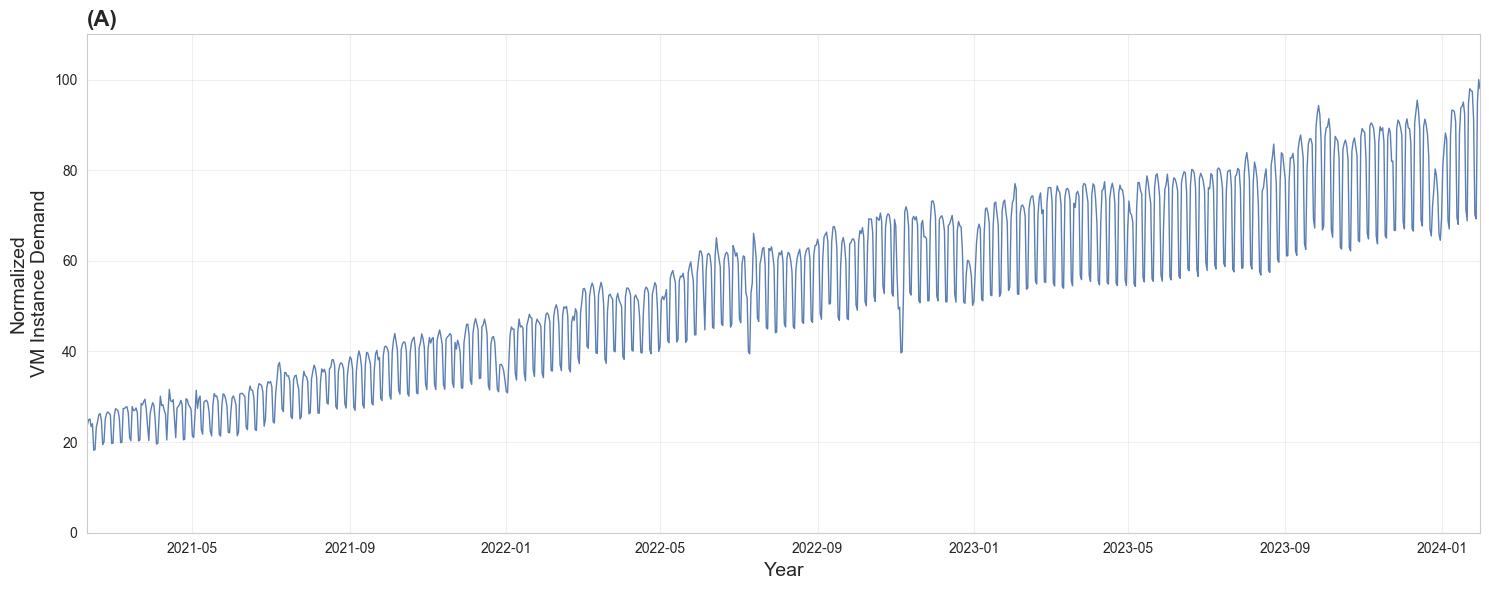

In [3]:
# aggregate globally and normalize to 0-100 scale
global_series = df.groupby('date')['demand'].sum().reset_index()
global_series['normalized_demand'] = (global_series['demand'] / global_series['demand'].max()) * 100

# Create the visualization
plt.figure(figsize=(15, 6))
plt.plot(global_series['date'], global_series['normalized_demand'], color='#5b7eb3', linewidth=1)

# Polish to match the research paper style
plt.title('(A)', loc='left', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Normalized\nVM Instance Demand', fontsize=14)
plt.grid(True, which='both', linestyle='-', alpha=0.3)
plt.xlim(global_series['date'].min(), global_series['date'].max())
plt.ylim(0, 110)
plt.tight_layout()
plt.show()

## 1. Analyze Demand Patterns by Day of Week

Understanding weekly seasonality helps us capture systematic demand fluctuations. We compute the average demand for each weekday and visualize it.

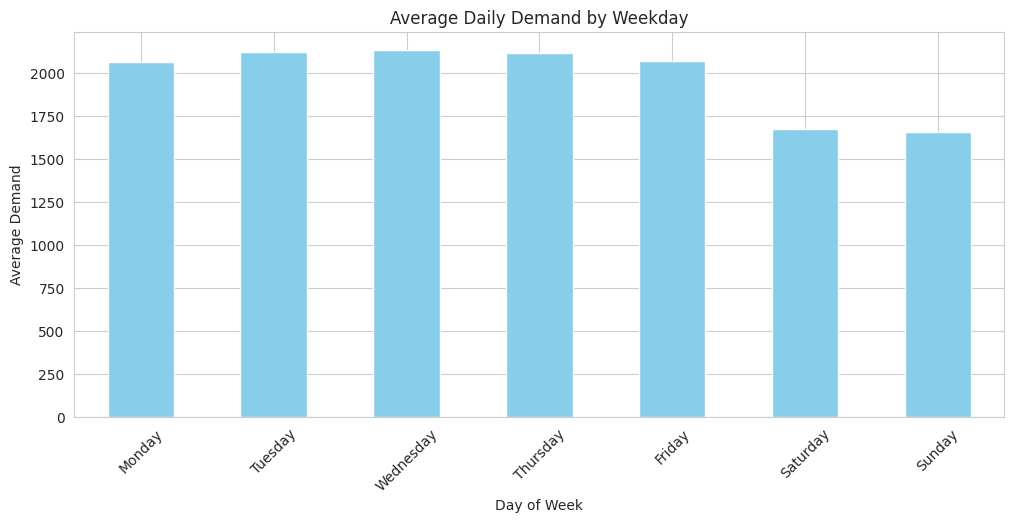

In [13]:
# Average demand by weekday
df['weekday'] = df['date'].dt.day_name()
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_avg = df.groupby('weekday')['demand'].mean().reindex(dow_order)

dow_avg.plot(kind='bar', color='skyblue')
plt.title('Average Daily Demand by Weekday')
plt.ylabel('Average Demand')
plt.xlabel('Day of Week')
plt.xticks(rotation=45)
plt.show()

## 2. Compare Demand Across Regions

Regional differences can affect capacity planning. We plot side-by-side boxplots for each region to visualize the variance.

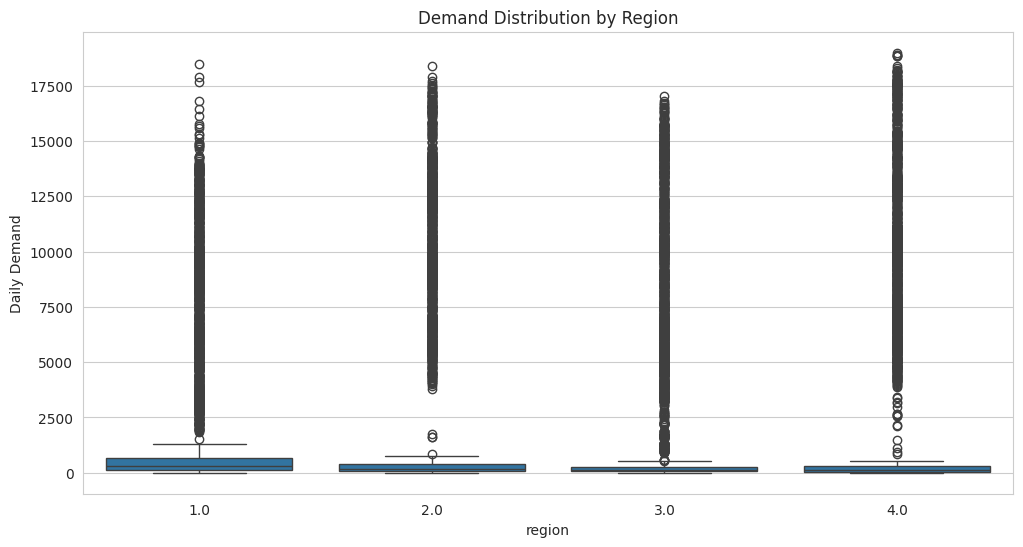

In [14]:
# Boxplot of demand by region
plt.figure(figsize=(12, 6))
sns.boxplot(x='region', y='demand', data=df)
plt.title('Demand Distribution by Region')
plt.ylabel('Daily Demand')
plt.show()

## 3. Examine Lag Features for Forecasting

Lagged demand can be a powerful predictor. We look at the correlation between today's demand and past values.

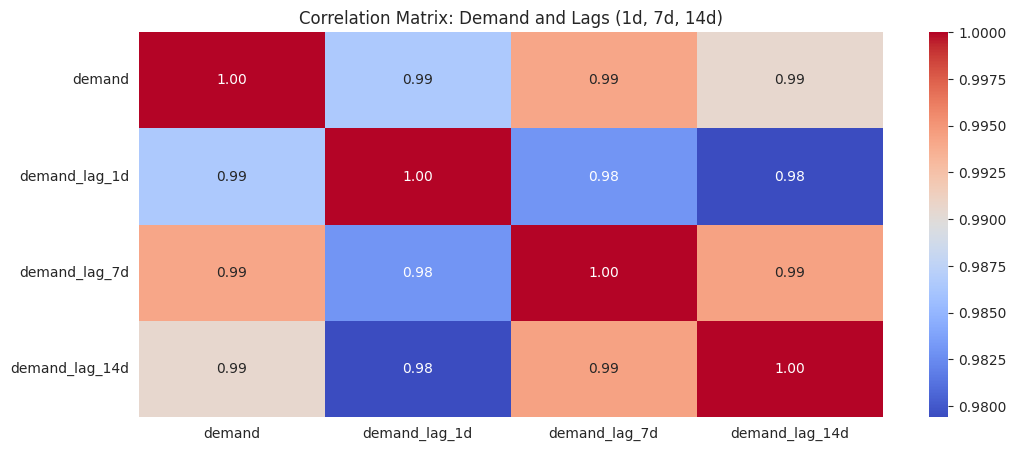

In [15]:
# Create additional lag features for analysis
# We ensure data is sorted by region, instance_type, and date
df.sort_values(['region', 'instance_type', 'date'], inplace=True)

# Calculate a 14-day lag (bi-weekly pattern) explicitly
df['demand_lag_14d'] = df.groupby(['region', 'instance_type'])['demand'].shift(14)

# Check correlation of demand lag features
lag_cols = ['demand', 'demand_lag_1d', 'demand_lag_7d', 'demand_lag_14d']
corr_matrix = df[lag_cols].corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix: Demand and Lags (1d, 7d, 14d)')
plt.show()

## 4. Simple Moving Average Forecasts

We implement a naïve 7-day moving-average forecast and evaluate its performance using Mean Absolute Error (MAE).

Overall MAE (Baseline 7d Rolling Avg): 240.22


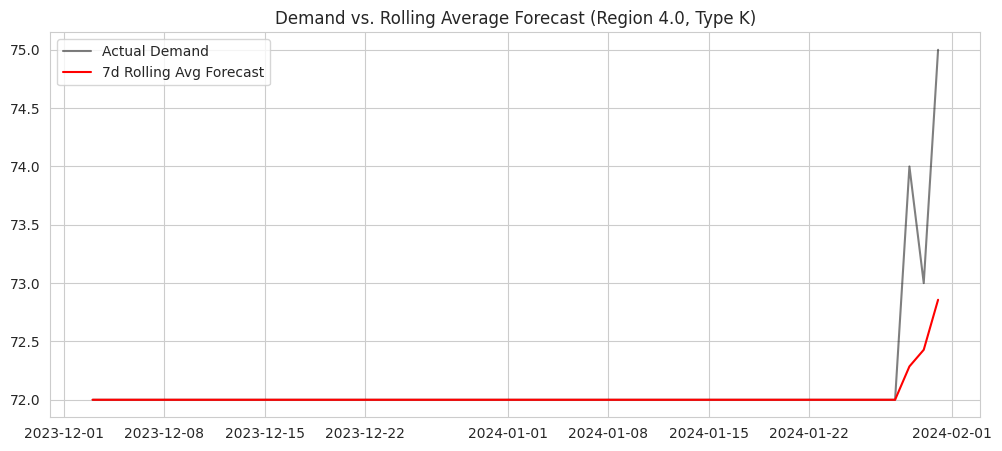

In [16]:
# Using the rolling average we already calculated in dbt as a baseline forecast
df['mae_error'] = (df['demand'] - df['demand_rolling_7d_avg']).abs()
overall_mae = df['mae_error'].mean()

print(f"Overall MAE (Baseline 7d Rolling Avg): {overall_mae:.2f}")

# Visualize for a specific instance type/region to see the fit
sample = df.tail(500) # Broadening sample to find valid data
if len(sample) > 0:
    # Get first available region/type for plot
    r = sample['region'].iloc[0]
    t = sample['instance_type'].iloc[0]
    plot_data = df[(df['region'] == r) & (df['instance_type'] == t)].tail(60)
    
    plt.plot(plot_data['date'], plot_data['demand'], label='Actual Demand', color='black', alpha=0.5)
    plt.plot(plot_data['date'], plot_data['demand_rolling_7d_avg'], label='7d Rolling Avg Forecast', color='red')
    plt.title(f'Demand vs. Rolling Average Forecast (Region {r}, Type {t})')
    plt.legend()
    plt.show()

## 5. Evaluate Safety Stock Recommendations

We compare the `total_capacity` (average + buffer) against actual demand to see how often we would have under-provisioned.

Stockout Rate with 95% Safety Stock: 34.25%


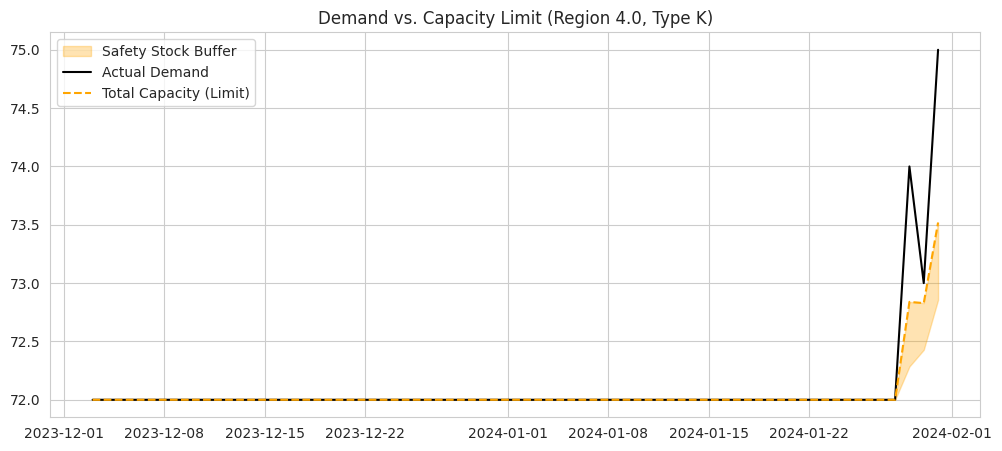

In [17]:
# Identify stockout events (where demand > total_capacity)
df['is_stockout'] = np.where(df['demand'] > df['total_capacity'], 1, 0)
stockout_rate = df['is_stockout'].mean() * 100

print(f"Stockout Rate with 95% Safety Stock: {stockout_rate:.2f}%")

# Visualize the buffer for the same sample
if len(sample) > 0:
    plt.fill_between(plot_data['date'], plot_data['demand_rolling_7d_avg'], plot_data['total_capacity'], color='orange', alpha=0.3, label='Safety Stock Buffer')
    plt.plot(plot_data['date'], plot_data['demand'], label='Actual Demand', color='black')
    plt.plot(plot_data['date'], plot_data['total_capacity'], label='Total Capacity (Limit)', color='orange', linestyle='--')
    plt.title(f'Demand vs. Capacity Limit (Region {r}, Type {t})')
    plt.legend()
    plt.show()

## 6. Formal Definitions (Academic Appendix)

Below are the formal definitions of the metrics utilized in this analysis, intended for inclusion in the ICPE 2026 submission.

**Rolling Average (7-day)** – The arithmetic mean of the previous seven observations:
$$ \bar{x}_{7,t} = \frac{1}{7} \sum_{i=1}^{7} x_{t-i} $$

**Rolling Standard Deviation (7-day)** – The square root of the variance over the same window:
$$ \sigma_{7,t} = \sqrt{\frac{1}{7} \sum_{i=1}^{7} (x_{t-i} - \bar{x}_{7,t})^2} $$

**Coefficient of Variation** – Relative dispersion:
$$ CV_{7,t} = \frac{\sigma_{7,t}}{\bar{x}_{7,t}} $$

**Safety Stock (95% confidence)** –
$$ SS_{95,t} = 1.96 \sigma_{7,t} $$

### Mean Absolute Error (MAE)
Measuring the average magnitude of errors in a set of forecasts, without considering their direction:
$$ MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i| $$

### Root Mean Squared Error (RMSE)
Measuring the square root of the average of squared errors, giving higher weight to large errors:
$$ RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2} $$

### Capacity Formula
The target provisioning level combining typical demand and an uncertainty buffer:
$$ Capacity_t = \mu_{7,t} + (z \times \sigma_{7,t}) $$
Where:
- $\mu_{7,t}$ is the 7-day rolling mean.
- $\sigma_{7,t}$ is the 7-day rolling standard deviation.
- $z$ is the z-score for the desired confidence interval (e.g., 1.96 for 95%).
